Python environment

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scvi
import hotspot

In [ ]:
sc.settings.n_jobs = 8

In [ ]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [ ]:
import matplotlib as mpl
# https://github.com/theislab/scanpy/issues/1720
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

### Read pre-processed data

In [ ]:
tmp = sc.read('data/core_GBmap.h5ad')

# filter the malignant population
cells = pd.read_csv('data/filtered_malignant.csv')
tmp.obs['cells'] = tmp.obs.index.values
adata = tmp[tmp.obs['cells'].isin(cells['cells'].values.tolist())].copy()
print(adata)

In [ ]:
adata.layers["counts"] = adata.X.copy()

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1000,
    batch_key="author",
    layer="counts",
    subset=True)

### Create SCVI model and train it on reference dataset

In [ ]:
sca.dataset.setup_anndata(adata, layer = 'counts', batch_key="author")

In [ ]:
vae = sca.models.SCVI(
    adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
    use_cuda = True # indicate to use gpu!
)

In [ ]:
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
vae.train(n_epochs=500, frequency=1, early_stopping_kwargs=early_stopping_kwargs)

INFO     Training for 500 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...:  68%|██████▊   | 339/500 [47:37<22:36,  8.42s/it]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  68%|██████▊   | 339/500 [47:46<22:41,  8.45s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  1864 s. / 500 epochs                                                


In [ ]:
reference_latent = sc.AnnData(vae.get_latent_representation())

In [ ]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent, resolution = 0.5)
sc.tl.umap(reference_latent)

In [ ]:
reference_latent.obsm['X_scVI'] = vae.get_latent_representation()

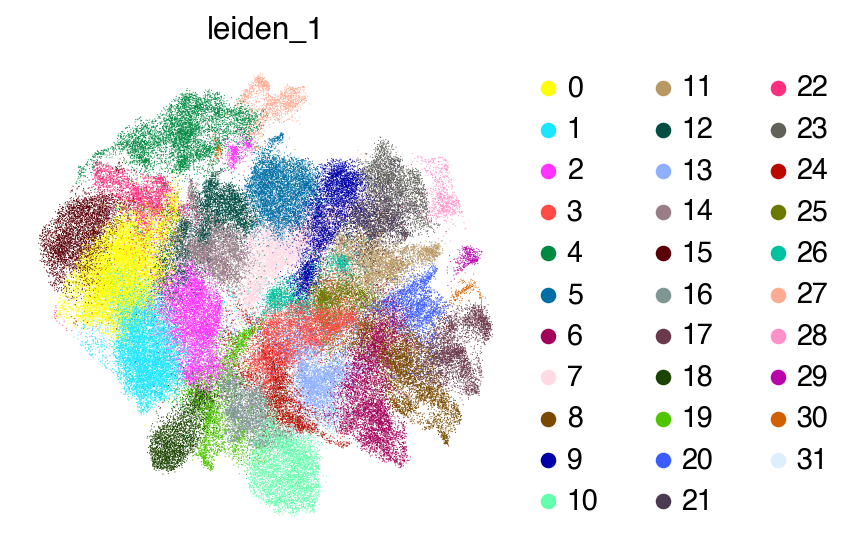

In [ ]:
sc.tl.leiden(reference_latent, resolution = 1, key_added= 'leiden_1')
sc.pl.umap(reference_latent,
           color=['leiden_1'],
           frameon=False,
           wspace=0.6,
           )

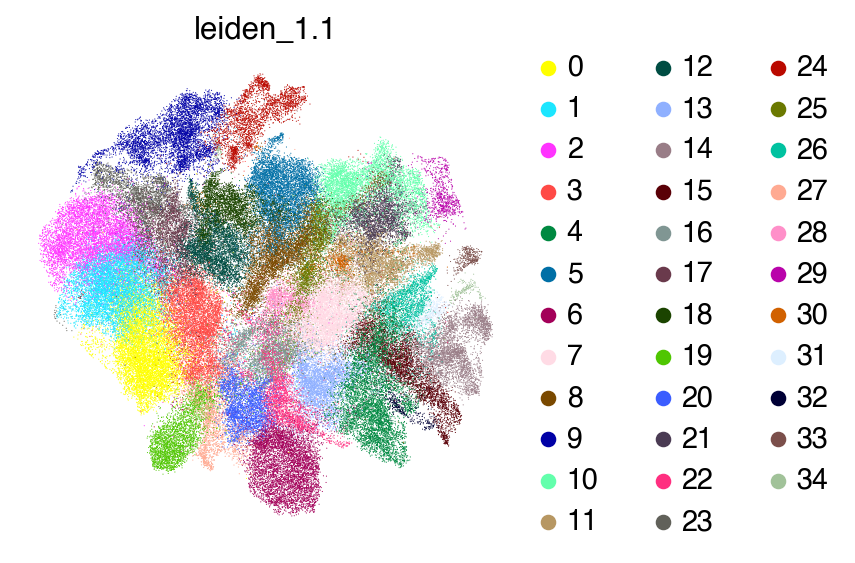

In [ ]:
sc.tl.leiden(reference_latent, resolution = 1.1, key_added= 'leiden_1.1')
sc.pl.umap(reference_latent,
           color=['leiden_1.1'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
reference_latent.write_h5ad('data/malignant_SCVI_1000hvg.5had')

In [ ]:
latent = vae.get_latent_representation()
counts = pd.DataFrame(adata.layers['counts'].astype('float64').todense().transpose(), columns=adata.obs.index.values, 
                      index=adata.var_names)
scvi_data = pd.DataFrame(latent,index=adata.obs.index.values)

### Creating the Hotspot object

In [ ]:
# Create the Hotspot object and the neighborhood graph
hs = hotspot.Hotspot(counts, model='danb', latent=scvi_data)

In [ ]:
hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

### Determining informative genes

In [ ]:
hs_results = hs.compute_autocorrelations(jobs=18)

hs_results.head(15)

100%|██████████| 1000/1000 [00:18<00:00, 54.15it/s]


,C,Z,Pval,FDR
Gene,,,,
RP11-620J15.3,0.552827,157363.932859,0.0,0.0
PLCG2,0.281832,127257.369216,0.0,0.0
VGF,0.493728,77214.522903,0.0,0.0
CTD-2339F6.1,0.471137,73063.757502,0.0,0.0
HBB,0.599086,57103.001713,0.0,0.0
RP11-745C15.2,0.439100,52215.733671,0.0,0.0
IGFBP2,0.601265,36322.654740,0.0,0.0
RP11-89N17.4,0.312286,30000.723157,0.0,0.0
NEAT1,0.525684,29748.405457,0.0,0.0


### Grouping genes into lineage-based modules

In [ ]:
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(500).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=18)

Computing pair-wise local correlation on 500 features...


 58%|█████▊    | 72422/124750 [32:37<24:07, 36.14it/s]  

In [ ]:
modules = hs.create_modules(
    min_gene_threshold=15, core_only=True, fdr_threshold=0.05
)

modules.value_counts()

### Plotting module correlations

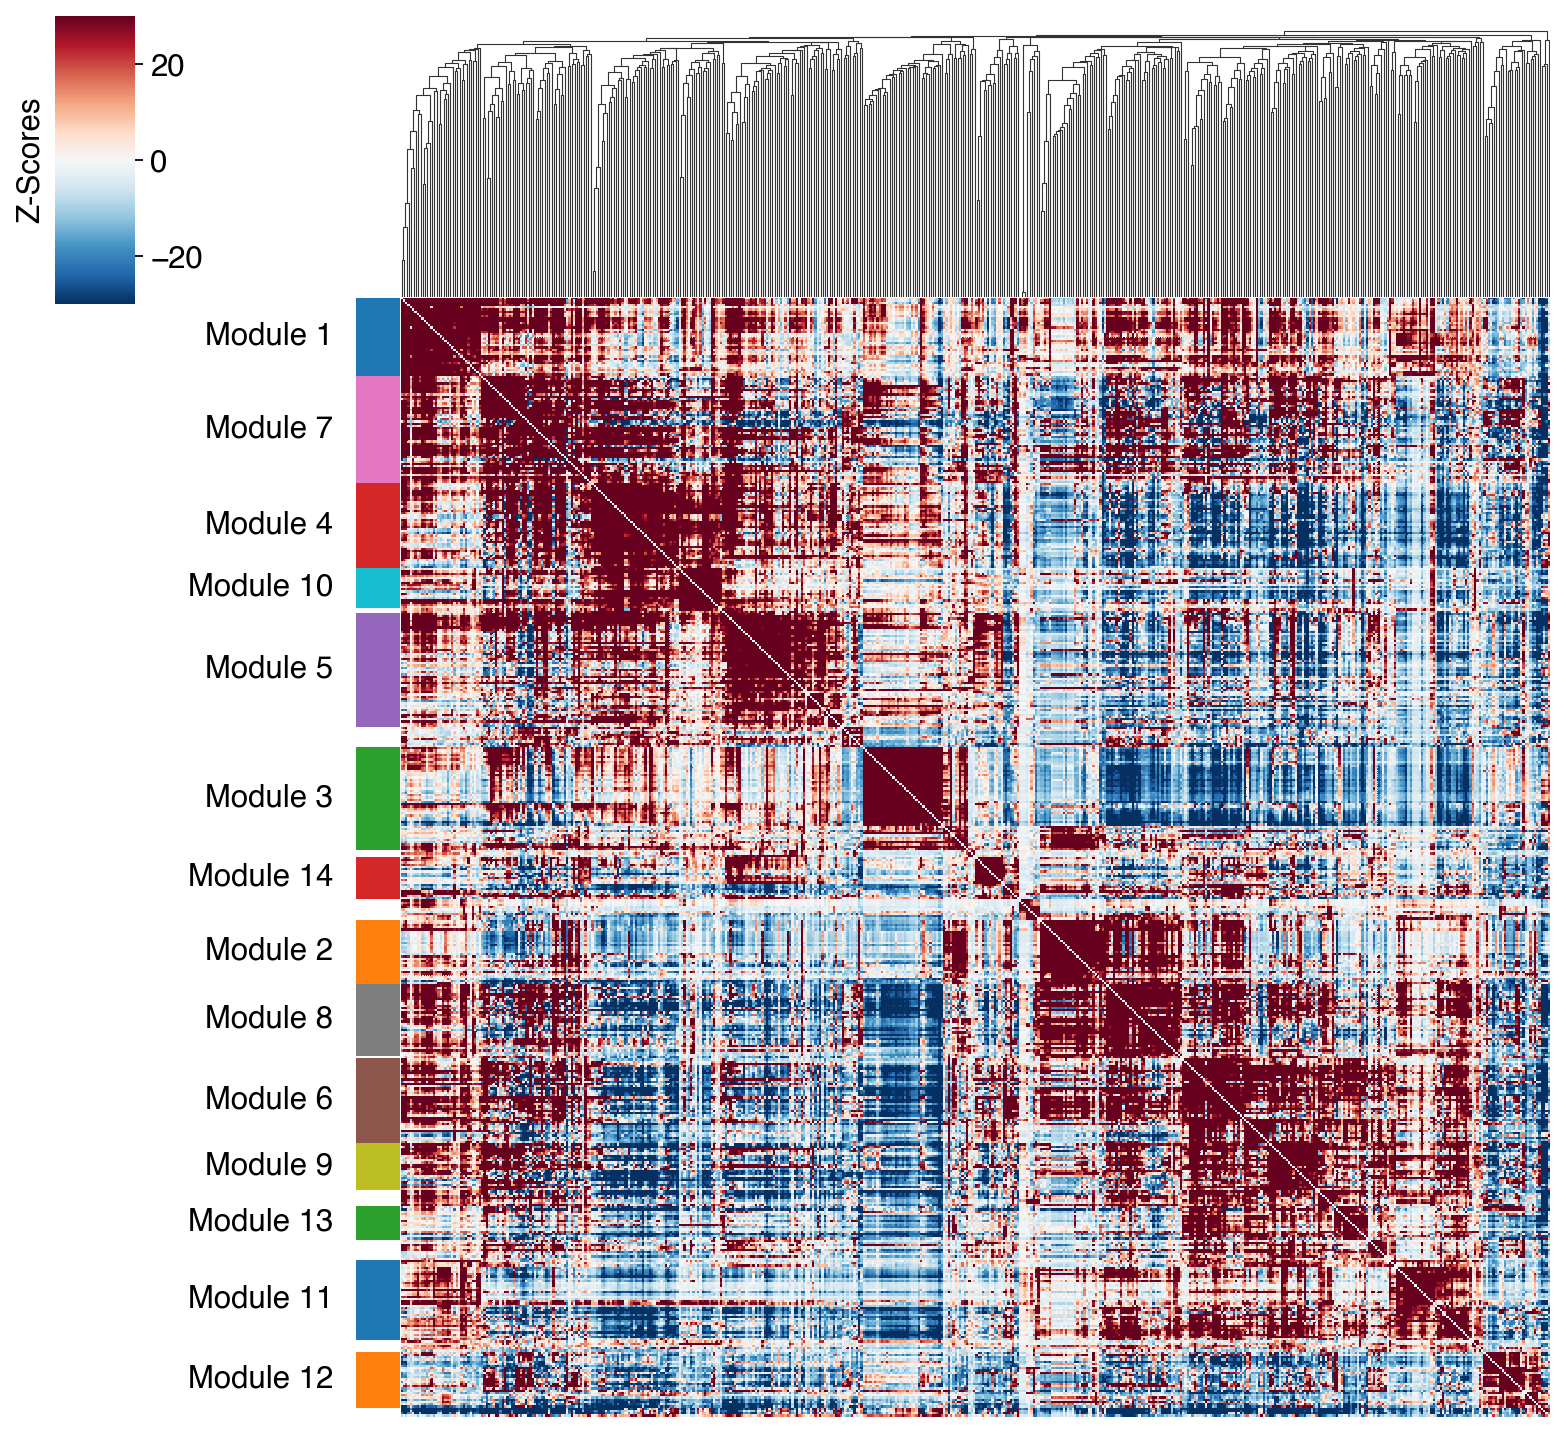

In [ ]:
hs.plot_local_correlations(vmin=-30, vmax=30)
plt.savefig('figures/malignant_plot_local_correlations.pdf')
# In the manuscript, the number of the modules where arranged in order from top to bottom

In [ ]:
# Show the top genes for a module

module = 1

results = hs.results.join(hs.modules)
results.to_csv('data/malignant_modules_hotspot_1000hvg.csv')

results = results.loc[results.Module == module]

results.sort_values('Z', ascending=False).head(10)

,C,Z,Pval,FDR,Module
Gene,,,,,
CCL4L2,0.481953,19716.861423,0.0,0.0,1.0
C1QC,0.560493,16793.901710,0.0,0.0,1.0
CCL4,0.432322,15647.000506,0.0,0.0,1.0
CCL3,0.395283,12882.138032,0.0,0.0,1.0
APOC1,0.464213,10512.546331,0.0,0.0,1.0
MRC1,0.516418,9977.885310,0.0,0.0,1.0
C1QB,0.350423,6918.266143,0.0,0.0,1.0
CCL20,0.089170,6382.781703,0.0,0.0,1.0
C1QA,0.290875,6214.718689,0.0,0.0,1.0


### Summary Module Scores

In [ ]:
module_scores = hs.calculate_module_scores()

module_scores.head()

  0%|          | 0/14 [00:00<?, ?it/s]

Computing scores for 14 modules...


100%|██████████| 14/14 [00:20<00:00,  1.49s/it]


,1,2,3,4,5,6,7,8,9,10,11,12,13,14
PJ017_0,-1.403234,-1.499440,-1.850763,-3.660279,-3.287228,-1.988320,-2.781830,0.025077,4.047882,-0.773397,13.541204,-1.746780,-1.142116,-1.072140
PJ017_3,0.320740,-1.053176,-1.815548,-3.577956,-3.208319,-2.563344,-2.677727,2.893378,-0.053098,-0.766569,21.613132,-1.800123,-1.162534,-1.192558
PJ017_4,0.704568,-1.608136,-1.847541,-3.720638,-3.342530,-2.964250,-2.494831,-0.856261,0.841846,-0.837809,3.728071,-1.732462,-1.001798,-1.023104
PJ017_5,7.783070,-1.156544,-1.629360,-3.561541,-3.096132,-1.924555,-2.318932,-1.073788,-0.568761,-0.795418,29.206960,-1.929143,-1.139820,-1.031178
PJ017_7,-0.386003,-0.957386,-1.841547,-3.623084,-3.180293,-2.374946,-2.750453,2.830138,0.869430,-0.652819,12.029498,-1.725203,-1.164666,-1.203428


In [ ]:
module_scores.to_csv('data/malignant_modules_scores_hotspot.csv')